In [1]:
import pandas_profiling
import time
import random

import numpy as np
import pandas as pd

from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
from subprocess import call

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-uci/heart.csv


## Loading Data

In [2]:
df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Visualization

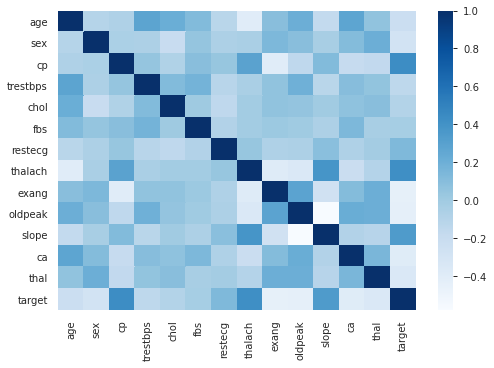

In [4]:
sns.heatmap(df.corr(), cmap='Blues')

So it is saying that there is no inter relations between two variables in the independet features [although I am guessing!]

So I just jump into data pre-processing step

## Pre-processing

In [5]:
X = df.drop(['target'],axis=1)
y = df['target']
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [6]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
indep_scaler = StandardScaler()
X_train = indep_scaler.fit_transform(X_train)
X_test = indep_scaler.transform(X_test)

In [9]:
relatable_columns = ['trestbps', 'chol', 'thalach', 'oldpeak']
relatable_columns_index = [3, 4, 7, 9]
colors = ["skyblue", "olive", "gold", "teal"]


1. For trestbps(3)
Kurtosis: 0.868480

2. For chol(4)
Kurtosis: 5.021364

3. For thalach(7)
Kurtosis: -0.192030

4. For oldpeak(9)
Kurtosis: 1.146011


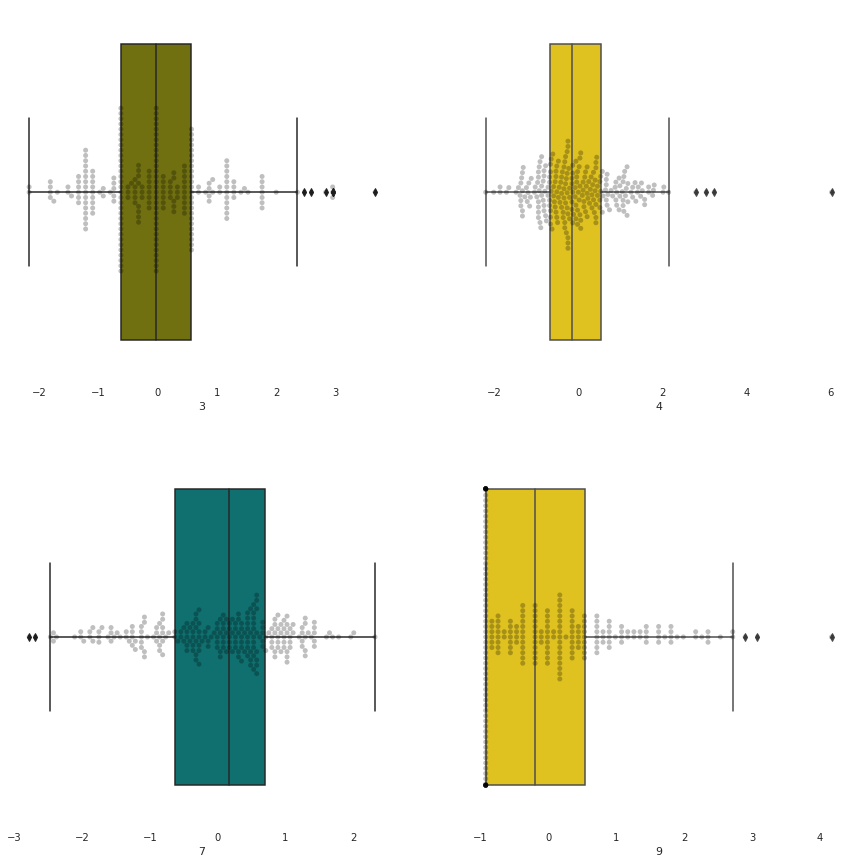

In [10]:
f, axes = plt.subplots(2, 2, figsize=(15, 15)) 
# sharex=True => if I use this parameter, then x- or y-axis will be shared among all subplots.

for index, each_column_index in enumerate(relatable_columns_index):
    print('\n{}. For {}({})'.format(index+1, df.columns[each_column_index], each_column_index))
    print("Kurtosis: %f" % pd.DataFrame(X_train)[each_column_index].kurt())
    sns.set(style="whitegrid")
    sns.boxplot(pd.DataFrame(X_train)[each_column_index],
                color=random.choice(colors), ax=axes[index//2, index%2])
    sns.swarmplot(pd.DataFrame(X_train)[each_column_index],color='black',alpha=0.25,
                 ax=axes[index//2, index%2])


1. For trestbps(3)
Skewness: 0.669584

2. For chol(4)
Skewness: 1.284200

3. For thalach(7)
Skewness: -0.513457

4. For oldpeak(9)
Skewness: 1.182153


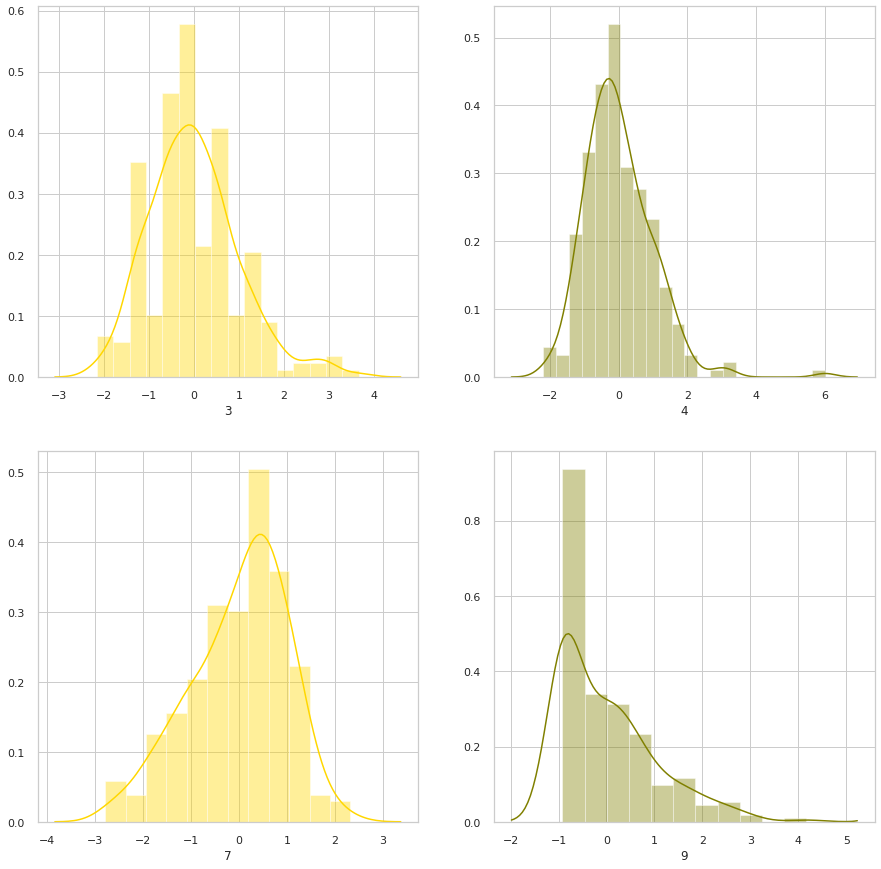

In [11]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

for index, each_column_index in enumerate(relatable_columns_index):
    print('\n{}. For {}({})'.format(index+1, df.columns[each_column_index], each_column_index))
    print("Skewness: %f" % pd.DataFrame(X_train)[each_column_index].skew())
    sns.distplot( pd.DataFrame(X_train)[each_column_index] , color=random.choice(colors), ax=axes[index//2, index%2])

Though I haven't worked on the skewness and kurtosis in this project because there is small samples, so if I do transformmations to get the good results, then there may be arise some ```NaN``` value, so then I also have to do work on those null values.

As this simple method is giving a good accuracy, so I wasn't go for further analysis!

## Model Building

In [12]:
kfolds = 4 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]
for name,model in base_models:
    clf = model
    cv_results = cross_val_score(clf, 
                                 X_train, y_train, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuarcy score: 0.7395 +/- 0.0635 (std) min: 0.6333, max: 0.8
RF_model cross validation accuarcy score: 0.8016 +/- 0.0232 (std) min: 0.7705, max: 0.8361
LR_model cross validation accuarcy score: 0.8057 +/- 0.0191 (std) min: 0.7833, max: 0.8361
XGB_model cross validation accuarcy score: 0.8057 +/- 0.0249 (std) min: 0.7667, max: 0.8333


The above results say that the model will perform perfectly on Random Forest Classifier and Logistic Regression algorithms, as the standard deviations are in the acceptable range thus I am going to examine further on these two algorithms only.

### Random Forest

In [13]:
rf = RandomForestClassifier(random_state=9)
rf.fit(X_train,y_train)

s = np.mean(cross_val_score(rf,X_train,y_train,scoring='roc_auc',cv=5))
print('The accuracy score for Random Forest is: ', s*100)

The accuracy score for Random Forest is:  91.15446282112948


### Logistic Regression

In [14]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)

s = np.mean(cross_val_score(lr,X_train,y_train,scoring='roc_auc',cv=5))
print('The accuracy score for Logistic Regression is: ', s*100)

The accuracy score for Logistic Regression is:  88.52820019486686


## Final Model Building

From the above section it can be said that Logistic Regression is giving better accuracy, yea! it is giving good accuracy on the cross validation but in case of prediction I saw that Random Forest Classification is giving better accuracy. 

So I am going to use Random Forest Classification as my final model!

In [15]:
final_model = RandomForestClassifier(n_estimators=60, random_state=9, 
                                     criterion='gini', max_features='sqrt',
                                    max_samples=9)
final_model.fit(X_train,y_train)

s = np.mean(cross_val_score(final_model,X_train,y_train,scoring='roc_auc',cv=5))
print('The accuracy score for RandomForest is: ', s*100)

predictions = final_model.predict(X_test)
print('Testing Accuracy: ', accuracy_score(y_test,predictions))

The accuracy score for RandomForest is:  88.9558281224948
Testing Accuracy:  0.8852459016393442


## Output Summary

Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

Training Accuracy : 0.8347107438016529
Testing Accuracy : 0.8852459016393442
Sensitivity :  0.8928571428571429
Specificity :  0.8787878787878788
The AUC Score:  0.8841594827586207


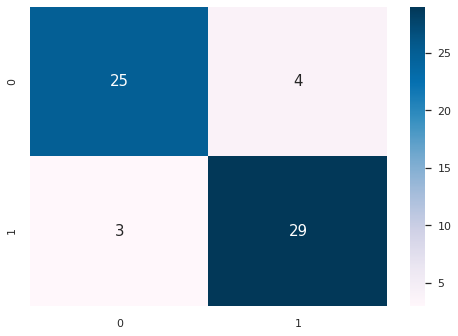

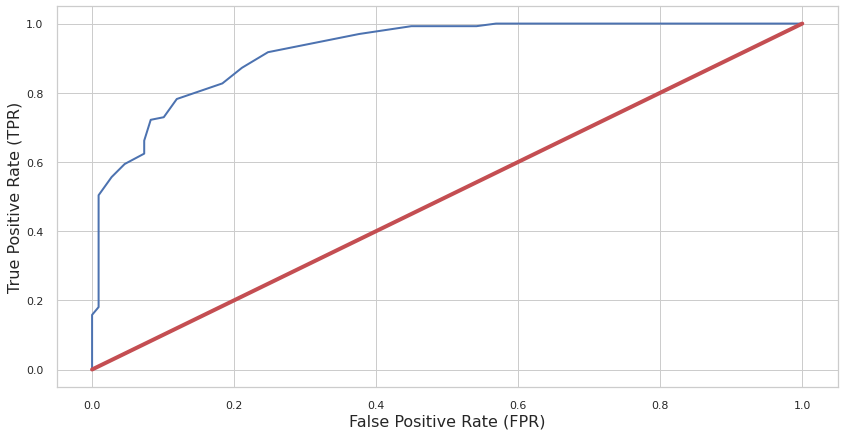

In [16]:
# Classification Report
print('Classification Report :')
print(classification_report(y_test,predictions))

# Traing & Testing Accuracy
print("Training Accuracy :", final_model.score(X_train, y_train))
print("Testing Accuracy :", final_model.score(X_test, y_test))

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# Sensitivity & Specificity
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

# ROC-AUC Curve Generating
print('The AUC Score: ',roc_auc_score(y_test, predictions))

y_scores = final_model.predict_proba(X_train)
y_scores = y_scores[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()